In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.cuda as cuda
import torch
import torchvision
import seaborn as sns

# Learning a normal distribution using generator-discriminator model

In [2]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(loc=mu, scale=sigma, size=(1,n)))
dist = get_distribution_sampler(5,2)
print(dist(10))


 4.0660  4.3717  4.6763  4.2089  2.9657  3.9205  8.3171  5.5833  3.5751  0.5782
[torch.FloatTensor of size 1x10]



In [3]:
def get_generator_sampler():
    return lambda m, n: torch.rand(m,n)
gen = get_generator_sampler()
gen(100,10)


 0.2051  0.3182  0.1162  ...   0.5390  0.7292  0.9281
 0.6200  0.5874  0.0930  ...   0.4613  0.2304  0.2910
 0.7985  0.7262  0.0594  ...   0.8446  0.4304  0.4113
          ...             ⋱             ...          
 0.6844  0.3313  0.3842  ...   0.1738  0.6191  0.5563
 0.6762  0.9547  0.6837  ...   0.0532  0.8404  0.4433
 0.7239  0.2519  0.4364  ...   0.8955  0.1144  0.3663
[torch.FloatTensor of size 100x10]

In [4]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        x = F.sigmoid(self.map3(x))
        return x

In [5]:
data_mean = 4
data_stddev = 1.25

g_input_size = 1
g_hidden_size = 50
g_output_size = 1

d_input_size = 100 # minibatch size
d_hidden_size = 50
d_output_size = 1 # sigmoid is applied here

batch_size = d_input_size

d_lr = 2e-4
g_lr = 2e-4

optim_betas = (0.9, 0.999)
num_epochs = 30000
print_interval = 200

d_steps = 1 # can be higher than g_steps  
g_steps = 1

In [6]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

In [7]:
d_sampler = get_distribution_sampler(data_mean, data_stddev)
g_sampler = get_generator_sampler()

D = Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)

criterion = nn.BCELoss() # binary cross entropy WHY??
d_optimizer = optim.Adam(D.parameters(), lr=d_lr, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_lr, betas=optim_betas)

## Training

In [15]:
def training(n_epochs=num_epochs, d_steps=d_steps, g_steps=g_steps):
    for epoch in range(n_epochs):
        for d_i in range(d_steps):
            D.zero_grad()
            
            # on real
            d_real_data = Variable(d_sampler(d_input_size))
            d_real_decision = D(d_real_data) 
            d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))
            d_real_error.backward() # calculate grtadients
            
            # on fake
            d_gen_input = Variable(g_sampler(batch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach() # Why? G souldnt train on these
            d_fake_decision = D(d_fake_data.t())
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))
            d_fake_error.backward()
            d_optimizer.step()
            
                
        for g_i in range(g_steps):
            G.zero_grad()
            
            gen_input = Variable(g_sampler(batch_size, g_input_size))
            g_fake_data = G(gen_input)
            fake_decision = D(g_fake_data.t())
            g_error = criterion(fake_decision, Variable(torch.ones(1)))
            
            g_error.backward()
            g_optimizer.step()
            
        if epoch % 3000 == 0:
            print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error)[0],
                                                            stats(extract(d_real_data)), stats(extract(d_fake_data))))
            sns.distplot(g_fake_data.data.numpy())
            plt.show()

0: D: 0.6633268594741821/0.706845223903656 G: 0.6721509695053101 (Real: [3.8426161760091784, 1.1716144160832203], Fake: [4.0195762133598327, 0.96921005231367852]) 


/home/sharan/anaconda2/envs/tfgpu/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


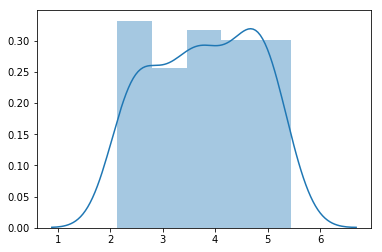

3000: D: 0.6966450810432434/0.7030592560768127 G: 0.7390025854110718 (Real: [4.2830185151100162, 1.1706263387323392], Fake: [3.9374215674400328, 1.2736035085394724]) 


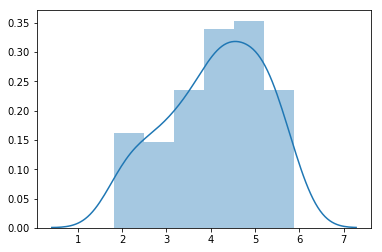

6000: D: 0.6625455617904663/0.7020412683486938 G: 0.6703689098358154 (Real: [4.0014768946170811, 1.138388440022194], Fake: [3.5212401604652404, 1.0026872592999798]) 


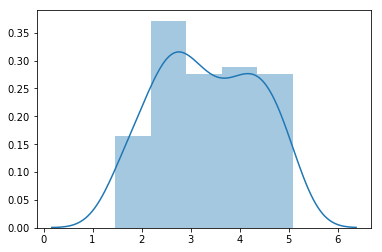

9000: D: 0.6529271602630615/0.7231238484382629 G: 0.6670590043067932 (Real: [4.1584475219249724, 1.1972374730143929], Fake: [3.3342023813724517, 1.1117462523745005]) 


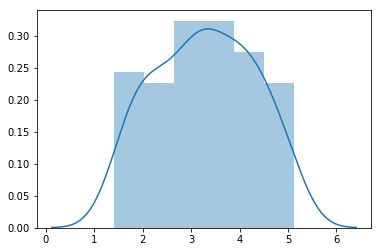

12000: D: 0.6815924644470215/0.732795238494873 G: 0.6959977149963379 (Real: [3.9214539670944215, 1.1188371063189879], Fake: [3.7522833645343781, 1.2671190724412298]) 


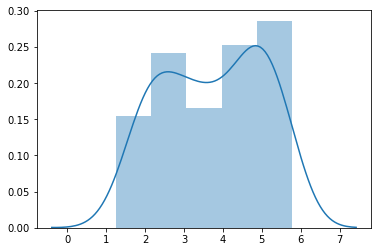

15000: D: 0.6671988368034363/0.7257999777793884 G: 0.7163664102554321 (Real: [4.1049639797210693, 1.1952352677272855], Fake: [3.8808420133590698, 1.0737409842361454]) 


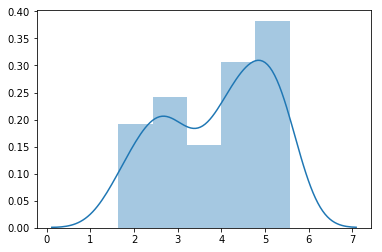

18000: D: 0.717406690120697/0.6540569067001343 G: 0.7071113586425781 (Real: [3.7945110505819319, 1.2057411263284596], Fake: [4.1945450520515442, 1.0558380635997886]) 


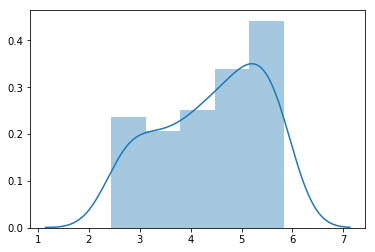

21000: D: 0.7590629458427429/0.7065709233283997 G: 0.6962123513221741 (Real: [4.0444670307636263, 1.1313047964773615], Fake: [4.0977610111236569, 1.0550389353994547]) 


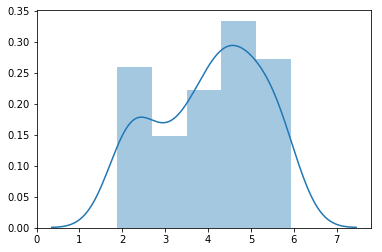

24000: D: 0.6912620067596436/0.6949945092201233 G: 0.6792791485786438 (Real: [3.984206451177597, 1.2325946277688946], Fake: [3.9417397928237916, 1.2070206964444579]) 


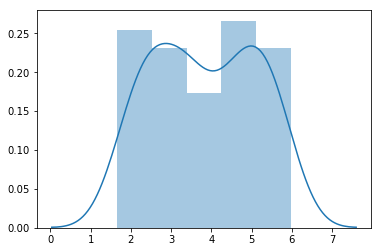

27000: D: 0.6564723253250122/0.6748866438865662 G: 0.6725302934646606 (Real: [3.8125078582763674, 1.1019208339208448], Fake: [3.6895325577259062, 1.0657624650122859]) 


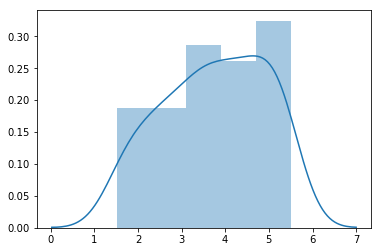

In [16]:
training()

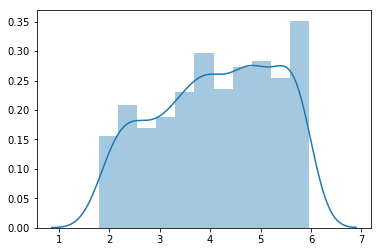

In [17]:
test = G(Variable(g_sampler(1000,1)))
test = test.data.numpy()
sns.distplot(test)